# LAB 4:  ANALZING NETWORK DATA LOG

### You are provided with the data file, in .csv format, in the working directory.  Write the program to extract the following informations.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from igraph import Graph, plot
from ipwhois import IPWhois

# Given SFlow Format in Table 1
format = ['Type', 'sflow_agent_address', 'inputPort', 'outputPort',
               'src_MAC', 'dst_MAC', 'ethernet_type', 'in_vlan', 'out_vlan',
               'src_IP', 'dst_IP', 'IP_protocol', 'ip_tos', 'ip_ttl',
               'src_transport_port', 'dst_transport_port', 'tcp_flags',
               'packet_size', 'IP_size', 'sampling_rate', '???']

# EXERCISE 4A: TOP TALKERS AND LISTENERS

### One of the most commonly used function in analyzing data log is finding out the IP address of the hosts that send out large amount of packet and hosts that receive large number of packets, usually know as TOP TALKERS and LISTENERS.  Based on the IP address we can obtained the organization who owns the IP address. 

In [ ]:
log_df = pd.read_csv('Data_2.csv', header = None, names = format)
log_df.dropna(axis=1, how='all', inplace=True) # Drop column with null values
log_df.head(10)

,Type,sflow_agent_address,inputPort,outputPort,src_MAC,dst_MAC,ethernet_type,in_vlan,out_vlan,src_IP,dst_IP,IP_protocol,ip_tos,ip_ttl,src_transport_port,dst_transport_port,tcp_flags,packet_size,IP_size,sampling_rate
0,FLOW,203.30.38.251,193,130,0031466b23cf,00239cd087c1,0x0800,919.0,919,74.125.10.59,137.132.38.238,17,0x00,63,443.0,62758,0x00,1396,1378,2048
1,FLOW,203.30.38.251,193,130,0031466b23cf,00239cd087c1,0x0800,919.0,919,173.194.22.215,137.132.228.29,6,0x00,63,443.0,39740,0x10,1438,1420,2048
2,FLOW,203.30.38.251,199,131,544b8cf9a7df,001cb0c88e40,0x0800,600.0,43,193.62.193.9,202.130.56.153,6,0x00,246,80.0,35794,0x18,272,250,2048
3,FLOW,203.30.38.251,193,131,0031466b23cf,001cb0c88e40,0x0800,919.0,43,74.125.130.132,192.122.131.33,6,0x00,52,443.0,5287,0x10,1418,1400,2048
4,FLOW,203.30.38.251,129,193,00135f21bc80,0031466b23cf,0x0800,11.0,919,155.69.160.69,74.125.68.139,17,0x60,59,48361.0,443,0x00,89,67,2048
5,FLOW,203.30.38.251,135,129,002688cd5fc7,00135f21bc80,0x0800,919.0,11,54.230.159.64,155.69.191.254,6,0x00,251,443.0,16657,0x10,1418,1400,2048
6,FLOW,203.30.38.251,129,193,00135f21bc80,0031466b23cf,0x0800,11.0,919,155.69.253.4,74.125.10.39,6,0x00,63,51374.0,443,0x10,74,52,2048
7,FLOW,203.30.38.251,129,193,00135f21bc80,0031466b23cf,0x0800,11.0,919,155.69.160.73,64.233.188.128,6,0x00,56,23153.0,443,0x10,1422,1400,2048
8,FLOW,203.30.38.251,200,130,80711fc76001,00239cd087c1,0x0800,280.0,919,129.99.230.54,137.132.22.74,6,0x00,53,48975.0,15000,0x10,1442,1420,2048
9,FLOW,203.30.38.251,200,129,80711fc76001,00135f21bc80,0x0800,280.0,11,210.32.0.65,155.69.16.255,6,0x00,41,80.0,56552,0x10,1522,1500,2048


In [ ]:
# Finding organisation given IP
def find_org(ip_addr):
    ip = IPWhois(ip_addr)
    result = ip.lookup_rdap()
    return result.get('network', {}).get('name')

In [ ]:
# Top 5 unique IP addresses by number of packets sent
top_talkers = log_df['src_IP'].value_counts().nlargest(5).to_frame()
org = []
for ip_addr in top_talkers.index:
    org.append(find_org(ip_addr))
top_talkers['Organisation'] = org    # append org. data to the dataframe

top_talkers = top_talkers.reset_index()
top_talkers

,No. of Packets,count,Organisation
0,13.107.4.50,5960,MSFT
1,130.14.250.7,4034,NLM-ETHER
2,155.69.160.38,3866,NTUNET1
3,171.67.77.19,2656,NETBLK-SUNET
4,155.69.199.255,2587,NTUNET1


In [ ]:
# Top 5 unique IP addresses by number of packets received
top_listeners = log_df['dst_IP'].value_counts().nlargest(5).to_frame()
org = []
for ip_addr in top_listeners.index:
    org.append(find_org(ip_addr))
top_listeners['Organisation'] = org    # append org. data to the dataframe

top_listeners = top_listeners.reset_index()
top_listeners

,No. of Packets,count,Organisation
0,137.132.228.33,5908,NUSNET
1,192.122.131.36,4662,A-STAR-AS-AP
2,202.51.247.133,4288,NUSGP
3,137.132.228.29,4022,NUSNET
4,103.37.198.100,3741,A-STAR-AS-AP


# EXERCISE 4B: TRANSPORT PROTOCOL 

### Using the IP protocol type attribute, determine the percentage of TCP and UDP protocol

In [ ]:
packet_df = log_df['IP_protocol'].value_counts().to_frame('No. of Packets')
packet_df = packet_df.reset_index()

percent_total = []
for i in range(len(packet_df)):
    percent_total.append(packet_df['No. of Packets'][i] * 100 / len(log_df))

packet_df['% total'] = percent_total
packet_df

# Given IP_Protocol 6 = TCP, IP_Protocol 17 = UDP
tcp_packet_df = packet_df.loc[packet_df['IP_protocol'] == 6]
udp_packet_df = packet_df.loc[packet_df['IP_protocol'] == 17]
frames = [tcp_packet_df, udp_packet_df]
final_df = pd.concat(frames)
final_df

,IP_protocol,No. of Packets,% total
0,6,137707,77.698723
1,17,36852,20.793085


# EXERCISE 4C: APPLICATIONS PROTOCOL

### Using the Destination IP port number determine the most frequently used application protocol.
(For finding the service given the port number https://www.webopedia.com/reference/well-known-tcp-port-numbers/)

https://www.adminsub.net/tcp-udp-port-finder/ did not work

In [ ]:
dest_port_df = log_df['dst_transport_port'].value_counts().nlargest(5).to_frame()
dest_port_df = dest_port_df.reset_index()
dest_port_df.columns = ['Destination Port', 'No. of Packets']

port_mapping = {
    1: 'TCP Port Service Multiplexer (TCPMUX)',
    5: 'Remote Job Entry (RJE)',
    7: 'ECHO',
    18: 'Message Send Protocol (MSP)',
    20: 'FTP — Data',
    21: 'FTP — Control',
    22: 'SSH Remote Login Protocol',
    23: 'Telnet',
    25: 'Simple Mail Transfer Protocol (SMTP)',
    29: 'MSG ICP',
    37: 'Time',
    42: 'Host Name Server (Nameserv)',
    43: 'WhoIs',
    49: 'Login Host Protocol (Login)',
    53: 'Domain Name System (DNS)',
    69: 'Trivial File Transfer Protocol (TFTP)',
    70: 'Gopher Services',
    79: 'Finger',
    80: 'HTTP',
    103: 'X.400 Standard',
    108: 'SNA Gateway Access Server',
    109: 'POP2',
    110: 'POP3',
    115: 'Simple File Transfer Protocol (SFTP)',
    118: 'SQL Services',
    119: 'Newsgroup (NNTP)',
    137: 'NetBIOS Name Service',
    139: 'NetBIOS Datagram Service',
    143: 'Interim Mail Access Protocol (IMAP)',
    150: 'NetBIOS Session Service',
    156: 'SQL Server',
    161: 'SNMP',
    179: 'Border Gateway Protocol (BGP)',
    190: 'Gateway Access Control Protocol (GACP)',
    194: 'Internet Relay Chat (IRC)',
    197: 'Directory Location Service (DLS)',
    389: 'Lightweight Directory Access Protocol (LDAP)',
    396: 'Novell Netware over IP',
    443: 'HTTPS',
    444: 'Simple Network Paging Protocol (SNPP)',
    445: 'Microsoft-DS',
    458: 'Apple QuickTime',
    546: 'DHCP Client',
    547: 'DHCP Server',
    563: 'SNEWS',
    569: 'MSN',
    1080: 'Socks',
    8160: 'Registered Port',
    15000: 'Registered Port',
    50930: 'Dynamic/private Ports'
}

dest_port_df['Service'] = dest_port_df['Destination Port'].map(port_mapping).fillna('Unknown')
dest_port_df

,Destination Port,No. of Packets,Service
0,443,43208,HTTPS
1,80,11018,HTTP
2,50930,2450,Dynamic/private ports
3,15000,2103,Registered Port
4,8160,1354,Registered Port


# EXERCISE 4D: TRAFFIC 

### The traffic intensity is an important parameter that a network engineer needs to monitor closely to determine if there is congestion. You would use the IP packet size to calculate the estimated total traffic over the monitored period of 15 seconds. (Assume the sampling rate is 1 in 2048)  

In [ ]:
# 1. Define the constants from the lab description.
sampling_rate = 2048
time_period_seconds = 15

# 2. Calculate the total size of all packets in the sample (in bytes).
total_sampled_bytes = sum(log_df['IP_size'])
# 3. Estimate the actual total traffic in bytes by applying the sampling rate.
estimated_total_bytes = total_sampled_bytes * sampling_rate
# 5. Calculate the traffic intensity (rate) in bytes per second (Bps).
bytes_per_second = estimated_total_bytes/ time_period_seconds
# 6. Convert Bps to a more readable unit, Megabytes per second (MBps).
megabytes_per_second = bytes_per_second / 1024 / 1024

print(f"Estimated Traffic Intensity = {megabytes_per_second:.3f} MBps")

Estimated Traffic Intensity = 22126.921 MBps


# EXERCISE 4E: ADDITIONAL ANALYSIS 

### Please append ONE page to provide additional analysis of the data and the insight it provides.
---

### Examples include:
### Top 5 communication pairs; 
### Visualization of communications between different IP hosts; etc.
---
### Please limit your results within one page (and any additional results that fall beyond one page limit will not be assessed). 

In [ ]:
# Top 5 unique communication pairs
comm_pairs_df = log_df.groupby(['src_IP', 'dst_IP']).size().sort_values(ascending = False).to_frame()
comm_pairs_df.columns = ['No. of Packets']
comm_pairs_df = comm_pairs_df.reset_index()
# comm_pairs_df

top_comm_df = comm_pairs_df[:5]
top_comm_df

,src_IP,dst_IP,No. of Packets
0,130.14.250.7,103.37.198.100,3739
1,171.67.77.19,192.122.131.36,2656
2,129.99.230.54,137.132.22.74,2097
3,137.132.228.42,137.131.17.212,1553
4,155.69.252.133,138.75.242.36,1475


In [ ]:
src_org = []
dst_org = []

for i in range(5):
    src_org.append(find_org(top_comm_df['src_IP'][i]))
    dst_org.append(find_org(top_comm_df['dst_IP'][i]))
    
top_comm_df.loc[:, 'Source Organisation'] = src_org
top_comm_df.loc[:, 'Destination Organisation'] = dst_org

top_comm_df = top_comm_df.reindex(['src_IP', 'Source Organisation', 'dst_IP', 
                                   'Destination Organisation', 
                                   'No. of Packets'], axis = 'columns')
top_comm_df

C:\Users\Jonathan Low\AppData\Local\Temp\ipykernel_16064\2382897663.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_comm_df.loc[:, 'Source Organisation'] = src_org
C:\Users\Jonathan Low\AppData\Local\Temp\ipykernel_16064\2382897663.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_comm_df.loc[:, 'Destination Organisation'] = dst_org


,src_IP,Source Organisation,dst_IP,Destination Organisation,No. of Packets
0,130.14.250.7,NLM-ETHER,103.37.198.100,A-STAR-AS-AP,3739
1,171.67.77.19,NETBLK-SUNET,192.122.131.36,A-STAR-AS-AP,2656
2,129.99.230.54,NAS-NET,137.132.22.74,NUSNET,2097
3,137.132.228.42,NUSNET,137.131.17.212,ORACLE-4,1553
4,155.69.252.133,NTUNET1,138.75.242.36,M1LIMITED-SG,1475


Generating graph with igraph and matplotlib...


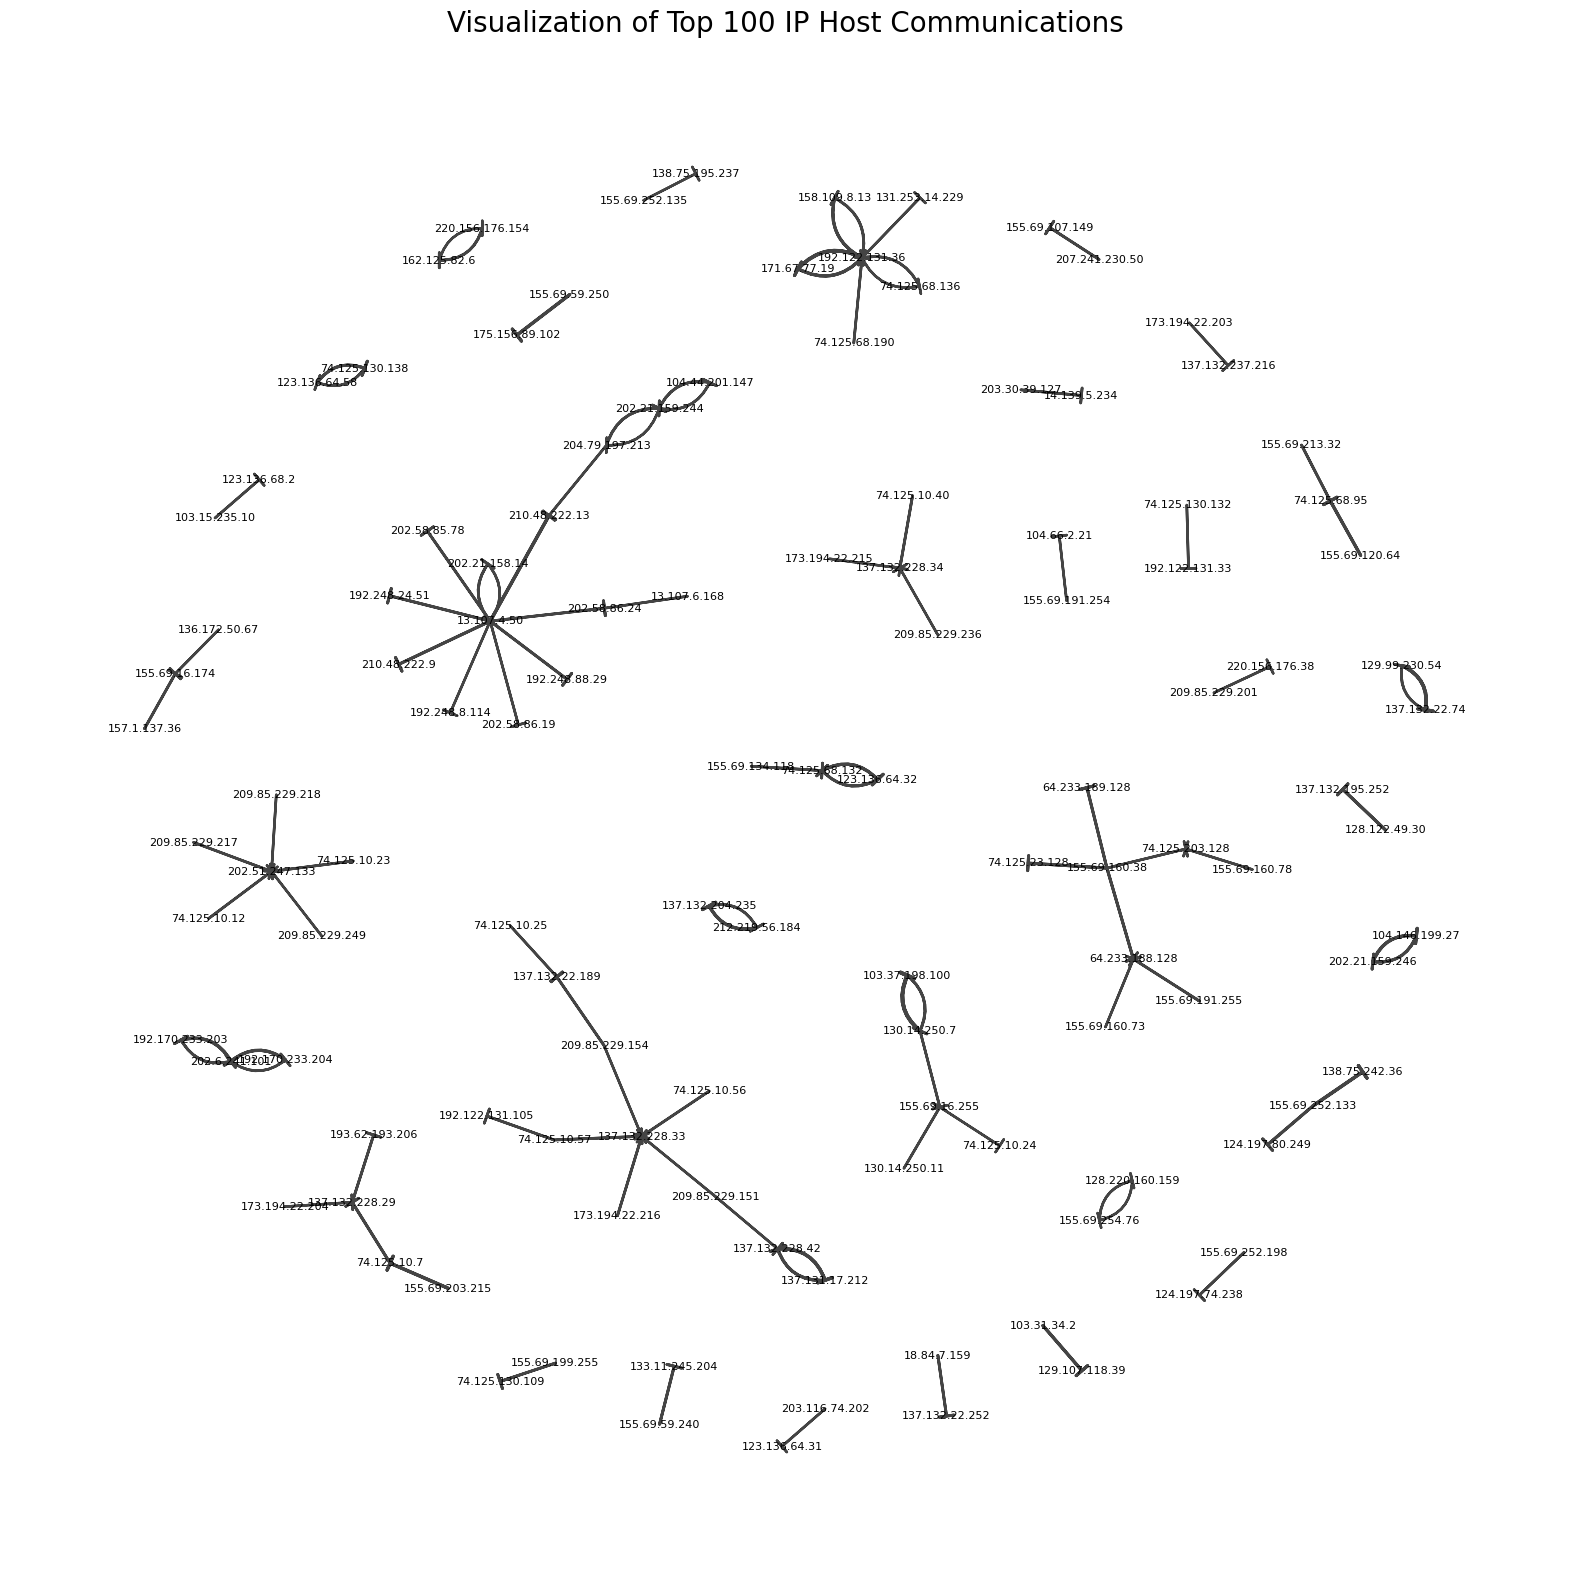

In [ ]:
# --- Data Preparation (using your existing 'log_df' DataFrame) ---

# Group by communication pair and get the top 100 most frequent ones
graph_series = log_df.groupby(["src_IP", "dst_IP"])\
                   .size()\
                   .nlargest(100)

# Convert the result into a DataFrame
graph_df = graph_series.to_frame().reset_index()
# The columns are now ['src_IP', 'dst_IP', 0], where column '0' holds the packet count.
# Create a list of tuples, which is the format igraph expects.
# The to_numpy() method converts the DataFrame to a NumPy array.
tuple_list = [tuple(edge) for edge in graph_df.to_numpy()]
# Create a directed graph from the list of tuples.
# The third element of each tuple is used as the edge 'weight'.
g = Graph.TupleList(tuple_list, directed=True, weights=True)

# Style the vertices (nodes)
g.vs["size"] = 15
g.vs["label_size"] = 8
g.vs["label"] = g.vs["name"] # Use the IP address (stored in 'name') as the label
g.vs["color"] = "skyblue"
# Style the edges (arrows)
# Use logarithmic scaling for a less exaggerated look, ensuring a minimum width of 1
g.es["width"] = [max(math.log(weight) / 1.5, 1) for weight in g.es['weight']]
# Make the arrow head size proportional to the line width
g.es["arrow_size"] = [width * 0.4 for width in g.es["width"]]

# --- Plotting (using matplotlib as the backend) --- 
# We already have matplotlib imported as plt from a previous cell
# Create a matplotlib figure and axes to draw on
fig, ax = plt.subplots(figsize=(20, 20))

# Tell igraph to plot to the matplotlib axes object instead of a new file.
# This bypasses the need for pycairo.
# Note: The styling parameters work differently with this backend, so they are adjusted.
# print("Generating graph with igraph and matplotlib...")
plot(
    g,
    target=ax,
    vertex_size=0.2,  # Smaller vertex size for matplotlib backend
    vertex_color="skyblue",
    vertex_label=g.vs["name"],
    vertex_label_size=8.0,
    edge_width=[w / 2 for w in g.es["width"]], # Adjust edge scaling
    edge_arrow_size=0.8
)

# Display the matplotlib plot
plt.title("Visualization of Top 100 IP Host Communications", size=20)
plt.show()

---

  # Additional Analysis and Insights

  The analysis of the Data_2.csv network log reveals a traffic pattern heavily concentrated among
  technology corporations, research agencies, and educational institutions, particularly those based in
  Singapore and the United States.

   1. Key Organizations: The most active "talker" is an IP address belonging to Microsoft (MSFT), while the
      top "listeners" are predominantly Singaporean institutions, including NUSNET (National University of 
      Singapore) and A-STAR (Agency for Science, Technology and Research). This suggests a significant flow
      of data originating from major tech companies and being consumed by local research and education
      networks.

   2. International Collaboration: The top communication pairs highlight strong international data
      exchange. The most active data stream is from the U.S. National Library of Medicine (NLM-ETHER) to
      Singapore's A-STAR. Similarly, the second most active stream is from Stanford University 
      (NETBLK-SUNET), also to A-STAR. This pattern strongly indicates that A-STAR is a major recipient of
      international research data.

   3. Traffic Flow and Hubs: Unlike a simple peer-to-peer network, the traffic flow appears somewhat
      centralized. The visualization graph would likely show organizations like A-STAR and NUSNET acting as    
      major "hubs" or destinations for traffic originating from various sources. The communication in the      
      top 5 pairs is largely one-directional, pointing towards data distribution or synchronization rather     
      than a two-way conversation.

   4. Nature of Data: The overwhelming dominance of HTTPS (port 443) traffic confirms that these
      communications are secure. This is consistent with the transfer of sensitive research data between
      institutions and with secure connections to services hosted by corporations like Microsoft and
      Oracle.